In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [6]:
# Install a compatible MedMNIST version
!pip -q install medmnist==3.0.2

import numpy as np
import tensorflow as tf
from medmnist import PneumoniaMNIST

# Load splits (as_rgb=False -> grayscale). Some envs return (N,28,28) (no channel)
train_set = PneumoniaMNIST(split='train', download=True, as_rgb=False)
test_set  = PneumoniaMNIST(split='test',  download=True, as_rgb=False)

# Ensure channel dimension exists: (N,28,28,1)
def ensure_channel(imgs):
    return imgs[..., np.newaxis] if imgs.ndim == 3 else imgs

x_train = ensure_channel(train_set.imgs).astype("float32") / 255.0  # (N,28,28,1)
y_train = train_set.labels.astype("int32").squeeze()
x_test  = ensure_channel(test_set.imgs).astype("float32")  / 255.0
y_test  = test_set.labels.astype("int32").squeeze()

# Map to 224×224 and RGB for ViT/DINO encoders
def to_224_rgb(x, y):
    x = tf.image.resize(x, (224, 224))      # (224,224,1)
    x = tf.image.grayscale_to_rgb(x)        # (224,224,3)
    return x, y

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
    .map(to_224_rgb, num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
    .map(to_224_rgb, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(32).prefetch(tf.data.AUTOTUNE)

# Keep the original variable name expected later
data_dir = train_ds

# (Optional) NumPy arrays for linear probe blocks expecting arrays later
X_train_np = np.stack([
    tf.image.grayscale_to_rgb(tf.image.resize(tf.convert_to_tensor(img), (224,224))).numpy()
    for img in x_train
])
X_test_np = np.stack([
    tf.image.grayscale_to_rgb(tf.image.resize(tf.convert_to_tensor(img), (224,224))).numpy()
    for img in x_test
])


In [8]:
# Install PyTorch + timm (CPU wheels are fine; will use GPU if available)
!pip -q install torch torchvision timm --extra-index-url https://download.pytorch.org/whl/cpu

import torch
import timm
from torchvision import transforms as T

device = "cuda" if torch.cuda.is_available() else "cpu"

# DINO ViT-S/16 feature extractor
dino_model = timm.create_model("vit_small_patch16_224.dino", pretrained=True, num_classes=0)
dino_model = dino_model.to(device).eval()

# Imagenet normalization for ViT
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

to_tensor = T.Compose([
    T.ToTensor(),                       # (H,W,C) [0,255] or [0,1] -> (C,H,W) float
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

In [10]:
import numpy as np
import torch

# ImageNet normalization (broadcasted over NCHW tensors)
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

def embed_numpy_images(np_images, model, device="cpu", batch_size=64):
    """
    np_images: float32 in [0,1], shape (N,224,224,3)
    returns: features array of shape (N, D)
    """
    model.eval()
    feats = []
    N = len(np_images)
    for i in range(0, N, batch_size):
        batch = np_images[i:i+batch_size]                              # (B,224,224,3)
        x = torch.from_numpy(np.transpose(batch, (0,3,1,2))).float()   # (B,3,224,224)
        # normalize to ImageNet stats
        x = (x - IMAGENET_MEAN) / IMAGENET_STD
        x = x.to(device, non_blocking=True)
        with torch.no_grad():
            z = model(x)                                               # (B, D)
        feats.append(z.cpu().numpy())
    return np.concatenate(feats, axis=0)


In [11]:
# Uses X_train_np / X_test_np from Cell 2 and dino_model/device from Cell 3
X_train_feats = embed_numpy_images(X_train_np, dino_model, device=device, batch_size=64)
X_test_feats  = embed_numpy_images(X_test_np,  dino_model, device=device, batch_size=64)
print("Train feats:", X_train_feats.shape, "Test feats:", X_test_feats.shape)


Train feats: (4708, 384) Test feats: (624, 384)


Linear probe accuracy on medical data (DINO features): 0.875


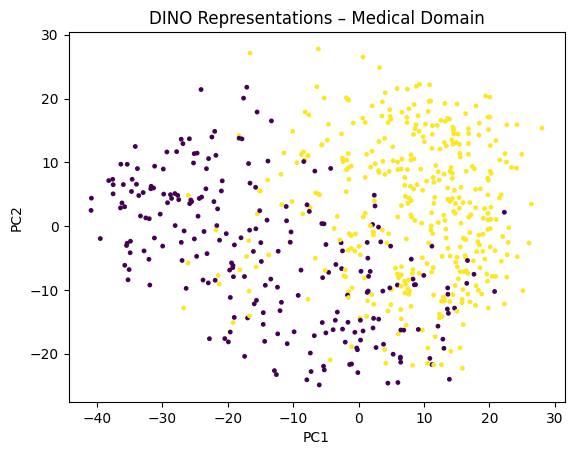

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# y_train / y_test come from Cell 2
clf = LogisticRegression(max_iter=2000, n_jobs=-1).fit(X_train_feats, y_train)
acc = accuracy_score(y_test, clf.predict(X_test_feats))
print(f"Linear probe accuracy on medical data (DINO features): {acc:.3f}")

Z = PCA(n_components=2, random_state=0).fit_transform(X_test_feats)
plt.scatter(Z[:,0], Z[:,1], c=y_test, s=6)
plt.title("DINO Representations – Medical Domain")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.show()
